# 1. Dependencies

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
import cv2 as cv
import matplotlib.pyplot as plt
import praw
import requests
import json
import csv
import time
import datetime


# 2. Data Acquisation

#### List of Properties of a submission(post is often reffered as submission), I am manually eliminating few of them, bacuase flair of the submission is least (or not) dependent on them ie: Flair is rarely dependent on author name, or subreddit etc

##### All Properties: dict_keys(['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_text', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls', 'removed_by_category', 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'steward_reports', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title', 'total_awards_received', 'url', 'whitelist_status', 'wls'])


##### Reference: 
- https://praw.readthedocs.io/en/latest/index.html
- https://github.com/pushshift/apia

In [3]:
# creating a reddit app instance to collect post data from r/india submreddit
reddit = praw.Reddit(client_id='pw8WCM92ySUjsQ', client_secret='y0MJFMWBtHXMLW2-3B2upsU2jYQ', user_agent='reddit-scrap', username='macabdul9', password='Sudo$0#1')

In [4]:
# We can get the submission either by id or url
subm = reddit.submission(id="fxqifi")

In [5]:
subm.num_comments

127

##### Turn Around Time(TAT) for getting all comments of a post is way higher using praw with submission_id than pushshift.io api comment search below code snippets illustrate the same

In [ ]:
# start_time = time.time()
# comment_ids = []
# count = 0
# for comment in subm.comments.list():
#     comment_ids.append(comment.id)
#     print(comment.body)
#     count+=1
# print("--- %s seconds ---" % (time.time() - start_time))
# print(count)

In [ ]:
# start_time = time.time()
# comments = getPushshiftSubData(','.join(comment_ids))
# count = 0
# for comment in comments:
#     print(comment['body'])
#     count +=1
# print("--- %s seconds ---" % (time.time() - start_time))
# print(count)

##### This function will receive url of a submission, num_commnents as arg and it will return the top 10 comment and mean comment score(upvote - downvote)

In [ ]:
def get_comments(url, num_comments):
    # call api using api wrapper
    subm = reddit.submission(url=url)
    comments_body = []
    sum_score = 0
    count = 0
    if num_comments > 0:
        for i, comment in enumerate(subm.comments.list()):

            # There may be some comments which has no body
            try : 
                comments_body.append(comment.body)
            except:
                comments_body.append('')

            # There exist some comments which has not given a score
            try:
                sum_score += comment.score
            except:
                sum_score += 0            
            count += 1
            # We only need 10 comments
            if (i+1)%10==0:
                break
    try:
        mean = sum_score/count
    except:
        mean = 0.0

    return " ".join(comments_body), mean

##### Function to call and retrive the data using pushshift api


In [ ]:
def getPushshiftSubData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=2000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

##### Properties to extract of a submission
- A custom property is a property derived from properties or can't be extracted using pushshift submission search endpoint

In [12]:
features = [
    'allow_live_comments', 'author', 'author_premium', 'can_mod_post', 'contest_mode', 'created_utc',
    'full_link', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_self', 'is_video',
    'link_flair_text', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
    'parent_whitelist_status', 'permalink', 'pinned', 'score', 'selftext', 'send_replies', 'spoiler',
    'stickied', 'title', 'total_awards_received', 'url'
]
custom_features = [
    'comments', 'mean_comment_score'
]

##### Function to extract the data 

In [ ]:
def collectSubData(subm):
    # extracting all information about a submission
    feature_values = [subm.get(key) for key in features]    
    comments, mean_comment_score = get_comments(subm.get('full_link'), subm.get('num_comments')) 
    feature_values.append(comments)
    feature_values.append(mean_comment_score)
    subStats[subm.get('id')] = feature_values

##### Query Parameters and Store Variables

In [ ]:
#Subreddit to query
sub='india'

#before and after dates
after = "1559347200"  # Sat, 01 Jun 2019 00:00:00 
before = "1561939199" # Sun, 30 Jun 2019 23:59:59  
query = "" # title should have either null string more 
subCount = 0
subStats = {}

##### Extracting the data from certain time period

In [ ]:
data = getPushshiftSubData(query, after, before, sub)# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    # print(len(data))
    if subCount % 1000 == 0:
        print(f'{subCount} submission collected')
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftSubData(query, after, before, sub)

print(len(data))

https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1559347200&before=1561939199&subreddit=india
1000 submission collected
2019-06-03 06:05:08
https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1559541908&before=1561939199&subreddit=india
2000 submission collected
2019-06-05 03:18:47
https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1559704727&before=1561939199&subreddit=india
3000 submission collected
2019-06-06 20:44:12
https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1559853852&before=1561939199&subreddit=india
4000 submission collected
2019-06-08 17:57:32
https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1560016652&before=1561939199&subreddit=india
5000 submission collected
2019-06-10 17:41:12
https://api.pushshift.io/reddit/search/submission/?title=&size=2000&after=1560188472&before=1561939199&subreddit=india
6000 submission collected
2019-06-12 09:57:51
https://ap

#### Write the json object into a pickle and/or storage all the data into csv a file

In [ ]:
with open("Submissions-June-2019.pkl", "wb") as f:
    pickle.dump(subStats, f)

In [ ]:
df = pd.DataFrame(data=list(subStats.values()), columns = features + custom_features, index=None)

In [ ]:
df.to_csv("Submissions-June-2019.csv", index=False)

#### Notes
- To extract the large (or sufficient) amount of data above code [2. Data Acquisation] was executed in multiple python environment to decreasem the amount of time taken to gather the data ie: To collect the submission of a monnth a code was executed in seperate environment.
- On the other hand multiple reddit api instances (one api app instance for each running environment) also helps to reduce the time(multiple running threads makes the request from same instance subtantially increases the waiting time)
- All submissions fromm Jan 1, 2019 to April 10, 2019 were  collected for this task and stored into the csv files(pkl as well), one file for each month's data (1 file for March 1, 2020 to April 10, 2020)
- A reliable internet connection is required for uninterrupted exectution


# 3. Exploratory Data Analysis

In [80]:
import plotly
import plotly.graph_objects as go
import calendar
import missingno as msno

In [67]:
plotly.offline.init_notebook_mode(connected=True)

In [68]:
# Read the csv files calendar combine them into single dataframe(or file)  file
# File names are pretty much self explanatory
df_1 = pd.read_csv("../Data/Submissions-Jan-2019.csv")
df_2 = pd.read_csv("../Data/Submissions-Feb-2019.csv")
df_3 = pd.read_csv("../Data/Submissions-March-2019.csv")
df_4 = pd.read_csv("../Data/Submissions-April-2019.csv")
df_5 = pd.read_csv("../Data/Submissions-May-2019.csv")
df_6 = pd.read_csv("../Data/Submissions-June-2019.csv")
df_7 = pd.read_csv("../Data/Submissions-July-2019.csv")
df_8 = pd.read_csv("../Data/Submissions-Aug-2019.csv")
df_9 = pd.read_csv("../Data/Submissions-Sep-2019.csv")
df_10 = pd.read_csv("../Data/Submissions-Oct-2019.csv")
df_11 = pd.read_csv("../Data/Submissions-Nov-2019.csv")
df_12 = pd.read_csv("../Data/Submissions-Dec-2019.csv")
df_13 = pd.read_csv("../Data/Submissions-Jan-2020.csv")
df_14 = pd.read_csv("../Data/Submissions-Feb-2020.csv")
# df_15 = pd.read_csv("../Data/SubmissionS-March-2020.csv")

##### Function to iterate over month

In [69]:
# List of dataframes
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14]

In [70]:
len(dfs)

14

In [71]:
def month_year_iter( start_month, start_year, end_month, end_year):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for i, ym in enumerate(range(ym_start, ym_end)):
        y, m = divmod( ym, 12)
        yield y, m+1, dfs[i]

In [72]:
# for yr, m, df in month_year_iter(1, 2019, 3, 2020):
#     print(yr, m, df.shape[0])

In [73]:
# Monthly submissions
monthly_submissions = {}
for year, month, df in month_year_iter(1, 2019, 3, 2020):
    monthly_submissions[str(calendar.month_name[month])+" "+str(year)] = df.shape[0]
#     print(, year)

In [74]:
months = list(monthly_submissions.keys())
submissions = list(monthly_submissions.values())

#### Monthly submissions plot 

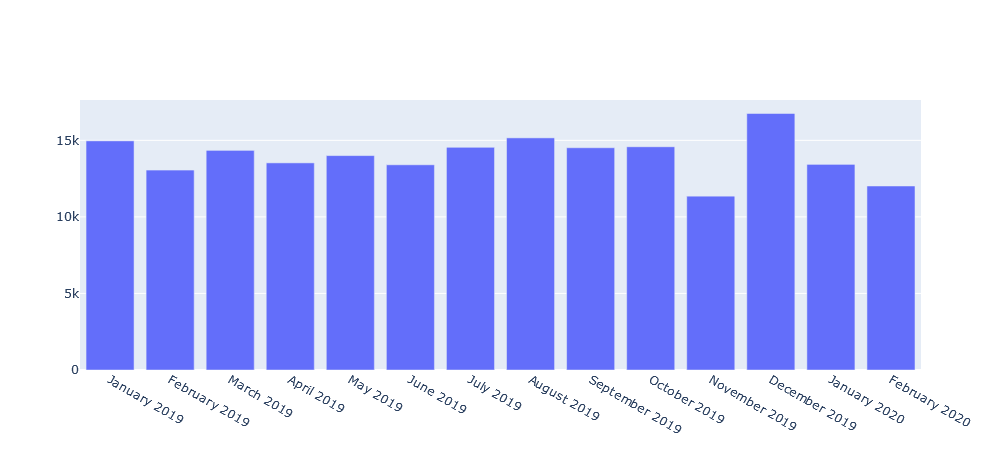

In [77]:
# monthly submissions
fig = go.Figure([go.Bar(x=months, y=submissions)])
fig.show()

In [78]:
### Nothing much ! I thought due to Covid19 outbreak we can see a spike in monthly submissions

In [83]:
df = pd.concat(dfs)

#### Missing Data Plot

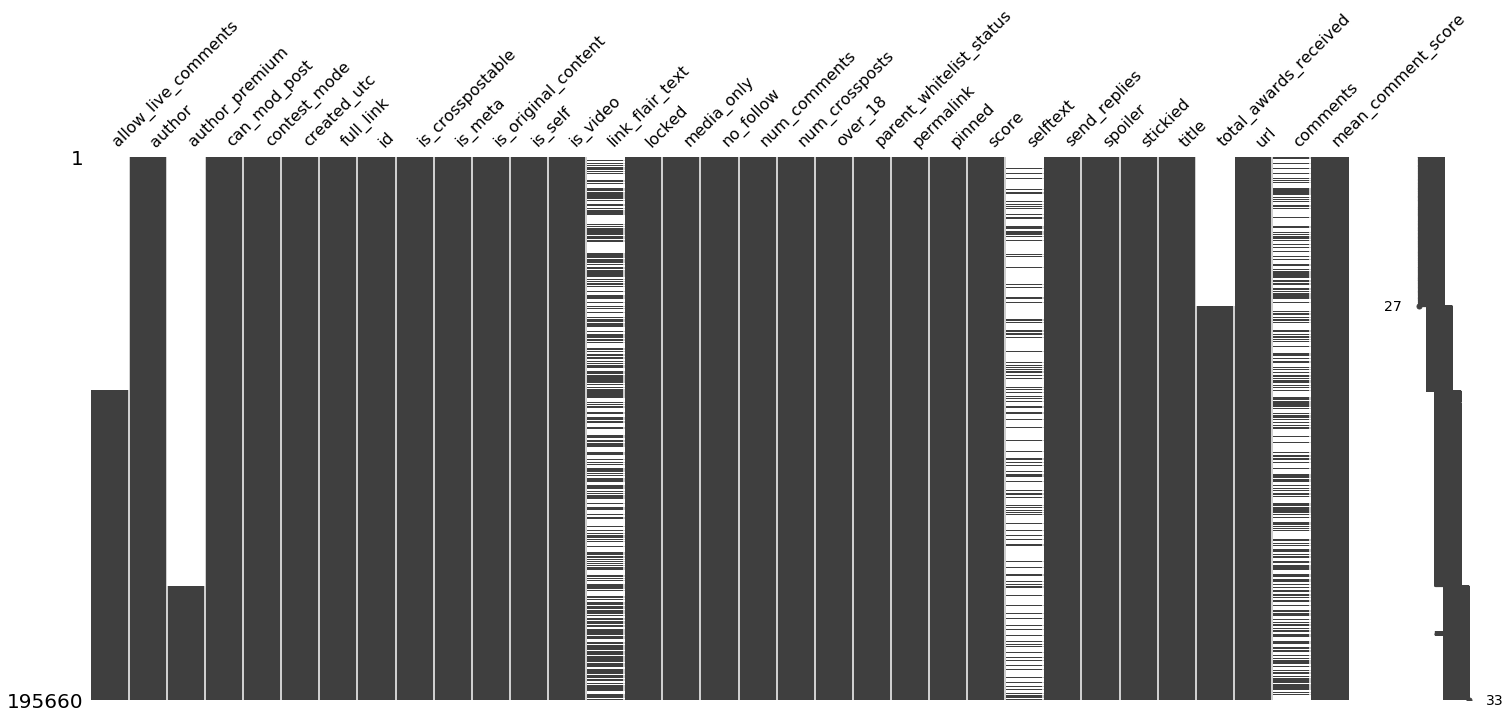

In [85]:
msno.matrix(df);

##### Note:
- link_flair_text = flair (target variable)
- self_text = submission(post) body

##### Total Entries = 195660
##### If missing plot we can see that there are many missing dependent and independent variables
##### Such as allo_live_comments author_premium, link_flair_text, self_text, total_awards_received, comments
##### There are lots of submissions whose target variable(flair) is missing either we have to drop  those entries or we need to immpute them,  we will catch them later.

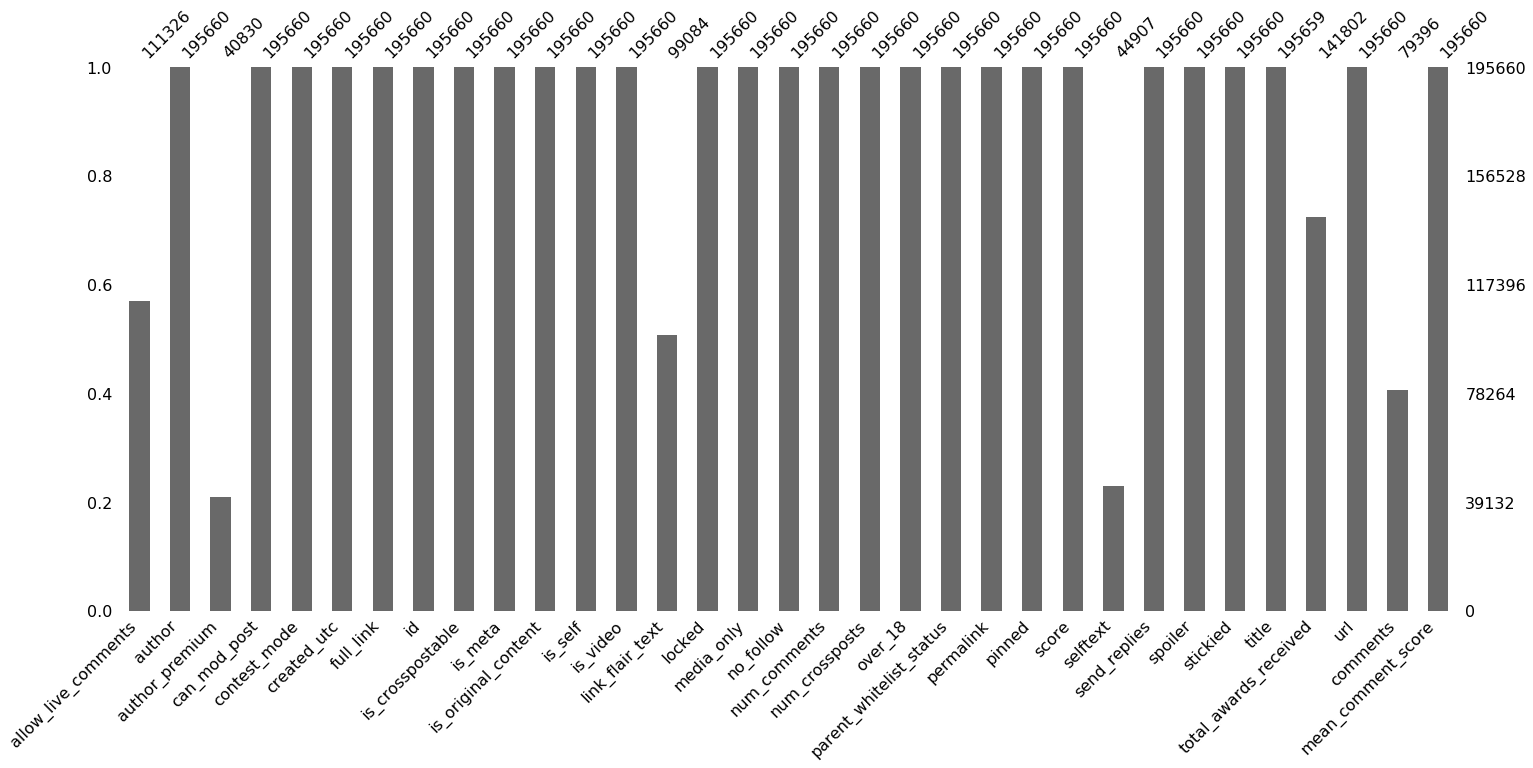

In [91]:
# bar plot of missing values | exactly how many values are missinng in each coloumn
msno.bar(df);

In [93]:
# nearly 50% submissions are without a target variables

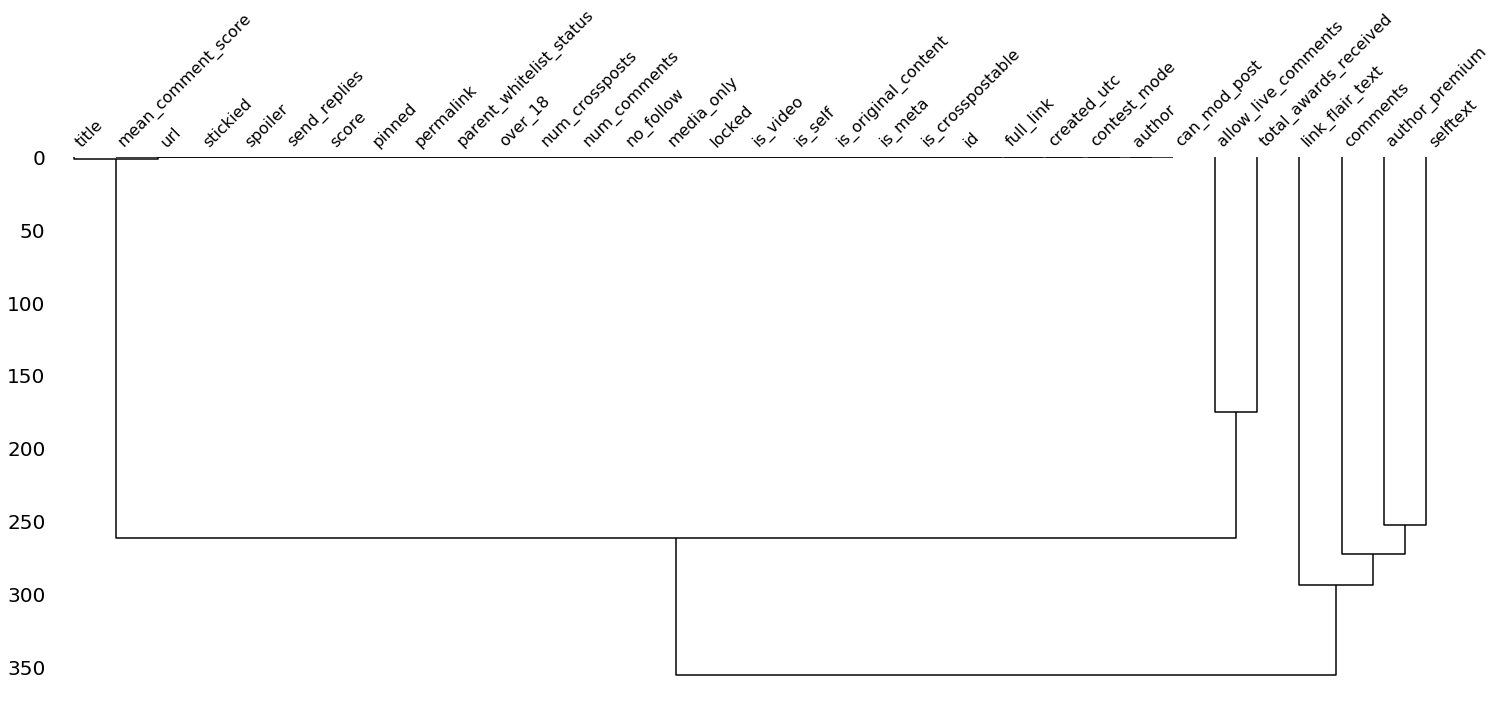

In [94]:
msno.dendrogram(df)